In [1]:
%matplotlib inline
#%matplotlib notebook
import pylab
import numpy as np
import nengo
import scipy


Here's a quick function for testing accuracy

In [8]:
def test(exponents, n_inputs=100, T_input=0.2, epsilon=0.001, show_plot=False, **kwargs):
    D = len(exponents)

    samples = np.random.uniform(epsilon, 1.0/D, size=(n_inputs, D))

    model = nengo.Network()
    with model:

        stim = nengo.Node(lambda t: samples[int(t / T_input) % n_inputs])
        p_stim = nengo.Probe(stim, synapse=None)

        total = nengo.Ensemble(n_neurons=kwargs['n_neurons'], dimensions=1)
        p = nengo.Probe(total, synapse=0.03)

        nengo.Connection(stim, total, transform=[[1,1]], synapse=None)
        
    sim = nengo.Simulator(model)
    sim.run(T_input*n_inputs, progress_bar=False)
    
    correct = np.zeros_like(sim.trange())
    for i in range(D):
        correct += sim.data[p_stim][:,i]**exponents[i]
    correct = nengo.synapses.filt(correct,nengo.synapses.Lowpass(0.03),  dt=sim.dt, x0=0)    

    if show_plot:
        pylab.plot(sim.trange(), sim.data[p])
        pylab.plot(sim.trange(), correct)    

    
    rmse = np.sqrt(np.mean((sim.data[p][:,0]-correct)**2))
    return rmse


You can just run it once to compute rms error

0.0063702494387562134

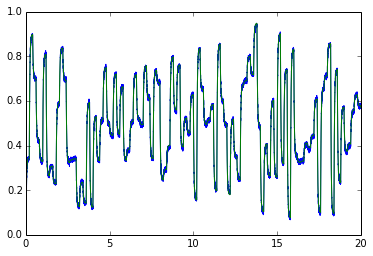

In [9]:
test(exponents=[1,1], n_neurons=100, show_plot=True)

Or run it many times and gather data

In [10]:
Ns = [10, 20, 50, 100, 200, 500, 1000]
data = {}
for N in Ns:
    data[N] = []



Run this block a few times to gather enough data

In [20]:
for i in range(10):
    print i
    for N in Ns:
        data[N].append(test(exponents=(1,1), n_neurons=N))

0
1
2
3
4
5
6
7
8
9


Now plot the data, using pandas and seaborn

In [28]:
import pandas as pd
table = []
for N, rmses in data.items():
    for rms in rmses:
        table.append((N, rms, np.log10(rms), np.log10(N)))
df = pd.DataFrame(table, columns=['n_neurons', 'error', 'log(error)', 'log(n_neurons)'])

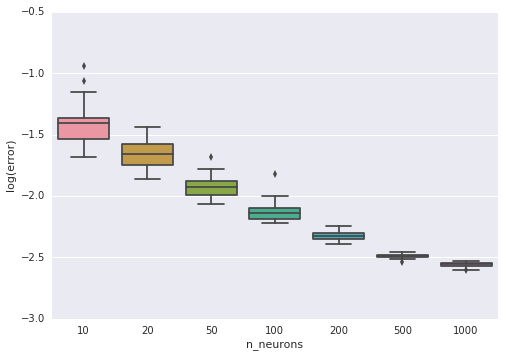

In [29]:
import seaborn as sns
ax = sns.boxplot('n_neurons', 'log(error)', data=df)


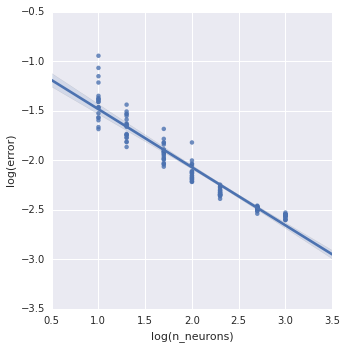

In [30]:
ax = sns.lmplot('log(n_neurons)', 'log(error)', data=df)